In [ ]:
# TO-DO

# 1 SCALE INPUT VARIABLES
# 3 TROUBLESHOOT ERRORS!
# 4 CENTROID CALCULATOR FUNCTION

In [1]:
# Import some modules which we will use later

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import copy


%matplotlib inline

In [2]:
# Read in the data
synthetic = open("./Data/Synthetic.rtf").read()

synthetic = synthetic[395:]
synthetic = synthetic.split("\\")

synthetic = [w.replace('\n', '') for w in synthetic]
synthetic = [w.replace(' ', '') for w in synthetic]
synthetic = synthetic[:-1]


synthetic_col1 = [int(w[:6]) for w in synthetic]
synthetic_col2 = [int(w[6:]) for w in synthetic]



print(len(synthetic_col1))
print(len(synthetic_col2))

synthetic = np.asarray((synthetic_col1,synthetic_col2))
synthetic = synthetic.T



print(synthetic.shape)
print(synthetic)




5000
5000
(5000, 2)
[[664159 550946]
 [665845 557965]
 [597173 575538]
 ...
 [650661 861267]
 [599647 858702]
 [684091 842566]]


## Functions

In [12]:
# Define custom function

## Basic functions for all algorithms

def euclidean_dist(x,y):
    """Calculates Euclidean distance between 2 n-dimensional vectors"""
    temp = x-y
    temp_2 = temp**2
    temp_sum = sum(temp_2)
    temp_sqrt = math.sqrt(temp_sum)
    
    return temp_sqrt

def benchmark_data_generation(n,p,K,std):
    """Generates benchmak data for clustering"""

    from sklearn.datasets.samples_generator import make_blobs
    X, y = make_blobs(n_samples=n, centers=K, n_features = p,
                  random_state=0, cluster_std=std)
    
    return X, y

## Functions for the MST algorithm

def adjacency_matrix(X):
    """Calculates distance matrix of input data points"""
    n = X.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(0,n):
        for j in range(i+1,n):
            dist_matrix[i,j]=euclidean_dist(np.array(X.iloc[i,]),np.array(X.iloc[j,]))
            
    return dist_matrix


def edge_vector(dist_matrix):
    """Creates list of edges/vertices with the corresponding distance"""
    n=len(dist_matrix)
    n_rows = int(n*(n-1)*(0.5))
    edge_dist = np.zeros((n_rows, 3))
    
    counter = 0
    
    for i in range(0,n):
        for j in range(i+1,n):
            
            edge_dist[counter,0] = i
            edge_dist[counter,1] = j
            edge_dist[counter,2] = dist_matrix[i,j]
            counter += 1
            
    return edge_dist

def edge_sorting(edge_vector):
    """Sorts the list of edges/distances"""
    sorted_matrix = edge_vector[edge_vector[:, -1].argsort()]
    
    return sorted_matrix


## Functions for MST/Kruskal algorithm
def mst_cluster(X, k):
    X = pd.DataFrame(X)
    matrix = adjacency_matrix(X)
    vector = edge_vector(matrix)
    sorted_vector = edge_sorting(vector)
    i = 0
    #initialize 1 cluster for each point
    points_set = X.join(pd.DataFrame(np.arange(0,len(X)), columns=['Cluster']))
    #set stopping point
    while points_set['Cluster'].nunique() > k:
        #start from firs row or sorted vector, get nodes
        node1 = sorted_vector[i][0].astype('int')
        node2 = sorted_vector[i][1].astype('int')
        #identify to which cluster each point belongs
        cluster1 = points_set.iloc[node1,2]
        cluster2 = points_set.iloc[node2,2]
        #if they are from the same cluster already, no connection can be made to avoid cycle
        if cluster1 != cluster2:
            # if they are different, the smaller cluster label will be given to the larger
            if cluster1 < cluster2:
                points_set.iloc[node2,2] = cluster1
            else:
                points_set.iloc[node1,2] = cluster2
        i = i +1
        
    points_set.drop(columns=[0,1])
    points_set['point_index'] = points_set.index
    points_set = points_set[['point_index', 'Cluster']]
    points_set = np.array(points_set)
    return points_set

## Functions for the k-means algorithms

def k_means_clustering(K,X):
    n = X.shape[0] # Number of observations
    d = X.shape[1] # dimensions
    X = np.array(X) # Convert pandas dataframe to numpy array

    # STEP 0
    # Get initial starting points
    initial_indices = np.random.randint(0,high=n,size=K) # Initial indices
    print(initial_indices)

    centroids = np.zeros((K, d))

    counter = 0
    for i in initial_indices:
        centroids[counter,:] = X[i,:]
        counter += 1

    #print(centroids)

    # STEP 1
    # Assign points to centroids
    cluster_table = np.zeros((n, 2))
    cluster_table[:,0] = np.arange(0,n,1)
    cluster_table = cluster_table.astype(int)
    
    
    change_tracker = True
    
    cost_values_db = []
    cost_values_dunn = []
    # Big loop
    while change_tracker:
        overall_change = 0
        for i in range(0,n):
            current_cluster = int(cluster_table[i,1])
            #print(current_cluster)
            current_dist = euclidean_dist(X[i,],centroids[current_cluster,])
            for j in range(0,K):
                temp = euclidean_dist(X[i,],centroids[j,])
                if temp<current_dist:
                    cluster_table[i,1]=j
                    current_dist = temp

                    overall_change += 1

        if overall_change == 0:
            change_tracker = False

        # STEP 2
        # Recalculate centroids
        #print(cluster_table)

        # Filter observations
        temp_table = cluster_table[cluster_table[:,1]==0]
        #print(temp_table)

        for i in range(0,K):
            # Filter for points in the given cluster
            temp_table2 = cluster_table[cluster_table[:,1]==i]

            # Calculating new centroids
            temp_array = np.zeros((len(temp_table2),d))
            counter = 0

            for j in temp_table2[:,0]:
                temp_array[counter,:] = X[j,:]
                counter += 1

            # Assign the new centroids
            centroids[i,:] = np.mean(temp_array, axis=0)
            
        cost_values_db.append(DB_index(X,centroids,cluster_table))
        cost_values_dunn.append(dunn_index(X,centroids,cluster_table))
            
    return centroids,cluster_table,cost_values_db,cost_values_dunn

## Functions for the Davies-Boulding-index

# Within cluster distances
def within_cluster_dist(X,centroids,cluster_table):
    sums = []
    for i in range(0,len(centroids)):
        temp = cluster_table[cluster_table[:,1]==i]
        temp_sum = 0
        if len(temp)!=0:
            for j in range(0,len(temp)):
                index = temp[j,0]
                current_dist = euclidean_dist(X[index,],centroids[i,])
                temp_sum += current_dist

            temp_sum = math.sqrt(temp_sum/len(temp))

        sums.append(temp_sum)
        
    return sums

# Cluster separation
def cluster_separation(centroids):
    combinations = int(len(centroids)*(len(centroids)-1)/2)
    #print(combinations)
    separations = np.zeros((combinations,3))
    #print(separations)

    counter = 0
    for i in range(0, len(centroids)):
        for j in range(i+1, len(centroids)):
            separations[counter,0] = i
            separations[counter,1] = j
            separations[counter,2] = euclidean_dist(centroids[i,],centroids[j,])

            counter += 1
            
    return separations

# Calculates Davies-Bouldien index
def DB_index(X,centroids,cluster_table):
    sums = within_cluster_dist(X,centroids,cluster_table)
    separations = cluster_separation(centroids)


    r_s = separations.copy()
    for i in range(0, len(r_s)):
        index_1 = int(r_s[i,0])
        index_2 = int(r_s[i,1])
        r_s[i,2] = (sums[index_1]+sums[index_2])/separations[i,2]

    d = []
    for j in range(0,len(centroids)):

        if j==0:
            temp1 = r_s[r_s[:,0]==j]
            max1 = max(temp1[:,2])
            d.append(max1)
        elif j==len(centroids)-1:
            temp2 = r_s[r_s[:,1]==j]
            max2 = max(temp2[:,2])
            d.append(max2)
        else:
            temp1 = r_s[r_s[:,0]==j]
            max1 = max(temp1[:,2])
            temp2 = r_s[r_s[:,1]==j]
            max2 = max(temp2[:,2])
            final_max = max(max1,max2)
            d.append(final_max)
            
    DB_index_val = sum(d)/len(centroids)
    
    return DB_index_val


## Functions for the Dunn-index
def max_within_distances(X,centroids,cluster_table):

    max_within_distances = []
    for k in range(0,len(centroids)):
        temp_table = cluster_table[cluster_table[:,1]==k]
        temp_max = 0
        for i in range(0,len(temp_table)):
            for j in range(i+1,len(temp_table)):
                index_1 = temp_table[i,0]
                index_2 = temp_table[j,0]
                current_value = euclidean_dist(X[index_1,],X[index_2,])
                if current_value>temp_max:
                    temp_max = current_value

        max_within_distances.append(temp_max)
        
    return max_within_distances


def min_between_distances(X,centroids,cluster_table):

    combinations = int(len(centroids)*(len(centroids)-1)/2)
    separations = np.zeros((combinations,3))

    counter = 0
    for i in range(0, len(centroids)):
        for j in range(i+1, len(centroids)):
            separations[counter,0] = i
            separations[counter,1] = j

            temp_table1 = cluster_table[cluster_table[:,1]==i]
            temp_table2 = cluster_table[cluster_table[:,1]==j]
            index_1 = temp_table1[0,0]
            index_2 = temp_table2[0,0]
            temp_min = euclidean_dist(X[index_1,],X[index_2,])
            for l in range(0,len(temp_table1)):
                for h in range(0,len(temp_table2)):
                    index_1 = temp_table1[l,0]
                    index_2 = temp_table2[h,0]
                    current_value = euclidean_dist(X[index_1,],X[index_2,])
                    if current_value<temp_min:
                        temp_min = current_value



            separations[counter,2] = temp_min

            counter += 1
            
    return separations

def dunn_index(X,centroids,cluster_table):
    separations_temp = min_between_distances(X,centroids,cluster_table)
    max_within_distances_temp = max_within_distances(X,centroids,cluster_table)
    
    result = min(separations_temp[:,2])/max(max_within_distances_temp)
    
    return result


## Function for checking indexes, effects of different parameter values

def index_params(n=300,p=2,K_true=3,std=0.9,K_hat=5):
    X, y = benchmark_data_generation(n=n,p=p,K=K_true,std = std)
    centroids, cluster_table, cost_values_db, cost_values_dunn = k_means_clustering(K_hat,X)
    db_final = cost_values_db[-1]
    dunn_final = cost_values_dunn[-1]
    
    return db_final,dunn_final

def index_params_plotter(param,start_value,end_value):
    dbs=[]
    dunns=[]
    integers = ['n','p','K_true','K_hat']
    floats = ['std']
    
    if param in integers:
        iterators = np.arange(start_value,end_value,1)
    else:
        iterators = np.arange(start_value,end_value,0.1)
        
    for i in iterators:
        #a = str(param)+'='+str(i)
        #print(type(a))
        temp_dict = {str(param) : i}
        #db_final,dunn_final = index_params(param=i)
        db_final,dunn_final = index_params(**temp_dict)
        # Use dictionary instead!!
        #db_final,dunn_final = index_params(K_hat=i)
        dbs.append(db_final)
        dunns.append(dunn_final)

    plt.plot(iterators,dbs)
    plt.plot(iterators,dunns)
    plt.legend(['DB-index','Dunn-index'])
    plt.title("Index values of the final K-means clustering as a function of: {}".format(param))
    plt.show()

## Testing

In [5]:
X, y = benchmark_data_generation(n=60,p=5,K=3,std = 0.9)

[15 53 57]
[[ 2.64166281 -1.11453316  7.7955637   9.14522256 -2.41926326]
 [ 5.86631091  0.77668801  1.33093176  8.28761671 -8.51482138]
 [ 1.05008999  4.19206368  2.20015647  1.00120897 -1.42629893]]
[0.35232965323108667, 0.2699182758201643, 0.2699182758201643]


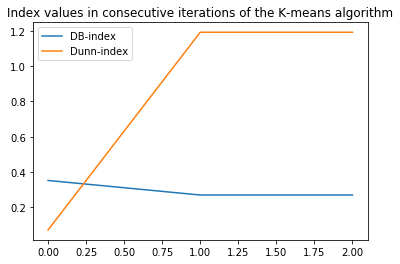

1.1916532768893362


In [6]:
centroids, cluster_table, cost_values_db, cost_values_dunn = k_means_clustering(3,X)
print(centroids)
#print(cluster_table)
print(cost_values_db)
plt.plot(cost_values_db)
plt.plot(cost_values_dunn)
plt.legend(['DB-index','Dunn-index'])
plt.title("Index values in consecutive iterations of the K-means algorithm")
plt.show()

print(cost_values_dunn[-1])

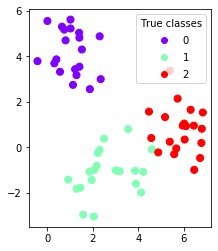

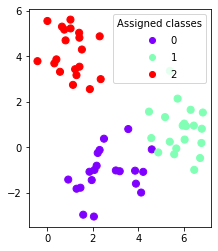

In [7]:
# Scatter plot - ORIGINAL
fig,ax = plt.subplots()
plt.axes().set_aspect('equal')
scatter=plt.scatter(X[:, 0], X[:, 1], c=y, s=50 , cmap='rainbow');
# produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="True classes")
plt.show()

# Scatter plot - K-MEANS
fig,ax = plt.subplots()
plt.axes().set_aspect('equal')
scatter=plt.scatter(X[:, 0], X[:, 1], c=cluster_table[:,1], s=50 , cmap='rainbow');
# produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Assigned classes")
plt.show()

### Testing with the real benchmark data

In [43]:
X = synthetic[:300,:]
centroids, cluster_table, cost_values_db, cost_values_dunn = k_means_clustering(15,X)

[189 220 244 290 262 157 246  96  73 196 146  78 282 269 102]


[[610728.         537373.21052632]
 [589121.85185185 560974.33333333]
 [546865.5        618631.        ]
 [635069.05263158 571544.36842105]
 [563744.24       568095.56      ]
 [610564.81818182 495603.27272727]
 [650081.4        608218.6       ]
 [617631.07142857 584571.14285714]
 [591947.15789474 628788.89473684]
 [643277.         660774.25      ]
 [593445.06666667 586985.06666667]
 [607546.         604123.61538462]
 [533617.         549028.7       ]
 [677443.19230769 577263.34615385]
 [604908.86885246 573467.93442623]]
[0.010749174891109149, 0.009596893762661879, 0.00896712715105384, 0.008632768667272977, 0.008469927958742905, 0.008430235143219158, 0.008467093271265212, 0.008460248038405475, 0.008442070160174075, 0.008321963829378767, 0.008188572016487785, 0.008099974950117017, 0.008027150460769386, 0.007960858461440429, 0.007894382422305725, 0.007867602909196582, 0.007817192419206536, 0.007761614184918692, 0.007728206193808776, 0.007728206193808776]


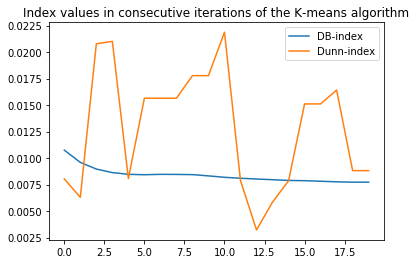

0.008819668233633966


In [44]:
print(centroids)
#print(cluster_table)
print(cost_values_db)
plt.plot(cost_values_db)
plt.plot(cost_values_dunn)
plt.legend(['DB-index','Dunn-index'])
plt.title("Index values in consecutive iterations of the K-means algorithm")
plt.show()

print(cost_values_dunn[-1])

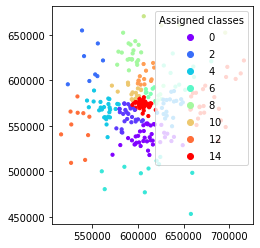

In [45]:
# Scatter plot - K-MEANS
fig,ax = plt.subplots()
plt.axes().set_aspect('equal')
scatter=plt.scatter(X[:, 0], X[:, 1], c=cluster_table[:,1], s=10 , cmap='rainbow');
# produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Assigned classes")
plt.show()

In [ ]:
## MST/Kruskal

In [46]:
result = mst_cluster(X,15)

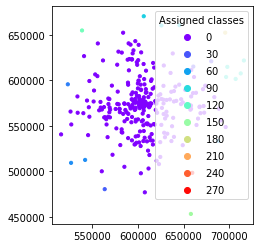

In [47]:
# Scatter plot - K-MEANS
fig,ax = plt.subplots()
plt.axes().set_aspect('equal')
scatter=plt.scatter(X[:, 0], X[:, 1], c=result[:,1], s=10 , cmap='rainbow');
# produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Assigned classes")
plt.show()

In [48]:
# Assign the new centroids
K = 15
d = 2

#points_set['Cluster'].nunique()
uniques = pd.DataFrame(result).iloc[:,1]
uniques = uniques.unique()
print(uniques)

# Get where the current cluster value is
index = int(result[0,1])
index = 274
#index = uniques[index]
unique_places = np.array([i==index for i in uniques])
temp = np.where(unique_places)[0]
print(temp)

indexer = 0
for i in range(0,len(result)):
    index = int(result[i,1])
    #index = uniques[index]
    unique_places = np.array([i==index for i in uniques])
    temp = np.where(unique_places)[0]
    result[i,1] = temp

centroids2 = np.zeros((K, d))

for i in range(0,K):
            # Filter for points in the given cluster
            temp_table2 = result[result[:,1]==i]

            # Calculating new centroids
            temp_array = np.zeros((len(temp_table2),d))
            counter = 0

            for j in temp_table2[:,0]:
                temp_array[counter,:] = X[j,:]
                counter += 1

            # Assign the new centroids
            centroids2[i,:] = np.mean(temp_array, axis=0)
            
print(centroids2)

[  0   2  52  60   3  83  23 101 130 155 191  33  45 100 274]
[14]
[[605551.17948718 572681.6996337 ]
 [545382.2        607141.2       ]
 [534267.5        511028.        ]
 [688015.         533535.        ]
 [598545.66666667 493389.66666667]
 [625820.66666667 663622.        ]
 [670503.5        617924.5       ]
 [705449.66666667 604209.33333333]
 [538571.         654649.        ]
 [657985.         453405.        ]
 [695646.         652231.        ]
 [563460.         480559.        ]
 [522993.         595581.        ]
 [707049.         618211.        ]
 [659529.         498474.        ]]


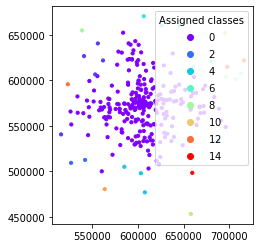

In [49]:
# Scatter plot - MST/Kruskal
fig,ax = plt.subplots()
plt.axes().set_aspect('equal')
scatter=plt.scatter(X[:, 0], X[:, 1], c=result[:,1], s=10 , cmap='rainbow');
# produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Assigned classes")
plt.show()

In [50]:
## Calculate index values for MST
db_temp = DB_index(X,centroids,result)
dunn_temp = dunn_index(X,centroids,result)

print(db_temp)
print(dunn_temp)

0.0220007024522594
0.01773789279649624


In [52]:
# Calculate index values for K-Means
print(cost_values_db[-1])
print(cost_values_dunn[-1])

0.007728206193808776
0.008819668233633966


## WIP (Work in Progress)

In [8]:
def index_params(n=300,p=2,K_true=3,std=0.9,K_hat=5):
    X, y = benchmark_data_generation(n=n,p=p,K=K_true,std = std)
    centroids, cluster_table, cost_values_db, cost_values_dunn = k_means_clustering(K_hat,X)
    db_final = cost_values_db[-1]
    dunn_final = cost_values_dunn[-1]
    
    return db_final,dunn_final

In [9]:

def index_params_plotter(param,start_value,end_value):
    dbs=[]
    dunns=[]
    integers = ['n','p','K_true','K_hat']
    floats = ['std']
    
    if param in integers:
        iterators = np.arange(start_value,end_value,1)
    else:
        iterators = np.arange(start_value,end_value,0.1)
        
    for i in iterators:
        #a = str(param)+'='+str(i)
        #print(type(a))
        temp_dict = {str(param) : i}
        #db_final,dunn_final = index_params(param=i)
        db_final,dunn_final = index_params(**temp_dict)
        # Use dictionary instead!!
        #db_final,dunn_final = index_params(K_hat=i)
        dbs.append(db_final)
        dunns.append(dunn_final)

    plt.plot(iterators,dbs)
    plt.plot(iterators,dunns)
    plt.legend(['DB-index','Dunn-index'])
    plt.title("Index values of the final K-means clustering as a function of: {}".format(param))
    plt.show()

[243   1]
[272 218 289]
[  0 199 228 116]
[171 263  58 253 109]


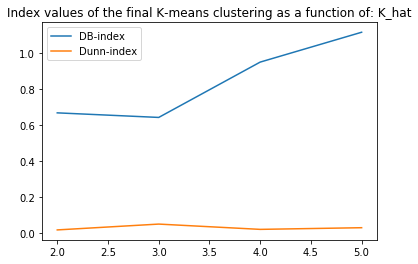

In [12]:
index_params_plotter(param='K_hat',start_value=2,end_value=6) # Algorithm should find 3 as optimal

## Support

In [3]:
# Test the custom function

x = np.array([1,2,3])
y = np.array([1,1,1])

print(euclidean_dist(x,y))

2.23606797749979


100
0.006729006703392466
      point_1  point_2  distance
3894     53.0     79.0  0.006729


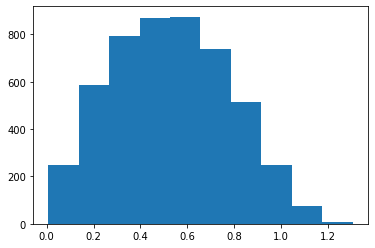

      index  point_1  point_2  distance
0      3770     50.0     96.0  1.305231
1      3743     50.0     69.0  1.265085
2       386      3.0     96.0  1.240727
3      2245     25.0     96.0  1.218423
4       359      3.0     69.0  1.205245
...     ...      ...      ...       ...
4945   1233     13.0     38.0  0.021243
4946   4047     57.0     58.0  0.018763
4947   1094     11.0     72.0  0.015639
4948   3586     47.0     62.0  0.015289
4949   3894     53.0     79.0  0.006729

[4950 rows x 4 columns]


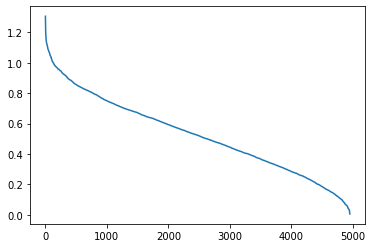

In [4]:
# Quick and dirty check for finding the 2 closest points

points = np.random.rand(100,2)

print(len(points))
#print(points)

results = np.random.rand(1,3)

for i in range(0,len(points)):
    for j in range(i+1,len(points)):
        dist = np.linalg.norm(points[i,:]-points[j,:])
        temp = np.array([i,j,dist]).reshape(1,3)
        #print(temp.shape)
        #print(results.shape)
        results = np.vstack((results,temp))

results = results[1:,:]        
#print(results)
print(min(results[:,2]))
a = min(results[:,2])


results = pd.DataFrame(results)
results.columns = ['point_1','point_2','distance']
#print(results.columns)

# Get the closest point
print(results[results['distance']<=a])


# Plot histogram of distance
plt.hist(results['distance'])
plt.show()

# Distance-sorted array
sorted_results = results.sort_values(by=['distance'],ascending=False).reset_index()
print(sorted_results)
plt.plot(sorted_results['distance'])
plt.show()

In [65]:
# Benchmark data generation
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=60, centers=5,n_features = 2,
                  random_state=0, cluster_std=0.2)

In [66]:
X = pd.DataFrame(X)
print(X.shape[0])

60


In [67]:
dist_matrix = np.zeros((len(y), len(y)))

In [68]:
for i in range(0,len(y)):
    for j in range(i+1,len(y)):
        dist_matrix[i,j]=euclidean_dist(np.array(X.iloc[i,]),np.array(X.iloc[j,]))

In [69]:
print(dist_matrix)

[[ 0.          0.32836797 14.35833286 ...  4.20854786  4.17960279
   5.30726092]
 [ 0.          0.         14.36333435 ...  4.30605762  4.25097055
   5.55465888]
 [ 0.          0.          0.         ... 10.34893277 10.2705343
  11.46289776]
 ...
 [ 0.          0.          0.         ...  0.          0.3515184
   2.87017855]
 [ 0.          0.          0.         ...  0.          0.
   3.22153427]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [70]:
temp = adjacency_matrix(X)
print(len(temp))

60


In [72]:
temp_vector = edge_vector(temp)
print(len(temp_vector))
print(temp_vector[21,:])

1770
[ 0.         22.          4.24637891]


In [73]:
sorted_list = edge_sorting(temp_vector)
print(len(sorted_list))

1770


In [74]:
# Parameters
K = 5 # Number of clusters
n = X.shape[0] # Number of observations
d = X.shape[1] # dimensions
X = np.array(X) # Convert pandas dataframe to numpy array

# STEP 0
# Get initial starting points
initial_indices = np.random.randint(0,high=n,size=K) # Initial indices
print(initial_indices)

centroids = np.zeros((K, d))

counter = 0
for i in initial_indices:
    centroids[counter,:] = X[i,:]
    counter += 1

print(centroids)

# STEP 1
# Assign points to centroids
cluster_table = np.zeros((n, 2))
cluster_table[:,0] = np.arange(0,n,1)
cluster_table = cluster_table.astype(int)

change_tracker = True
overall_change = 0
for i in range(0,n):
    current_cluster = int(cluster_table[i,1])
    #print(current_cluster)
    current_dist = euclidean_dist(X[i,],centroids[current_cluster,])
    for j in range(0,K):
        temp = euclidean_dist(X[i,],centroids[j,])
        if temp<current_dist:
            cluster_table[i,1]=j
            current_dist = temp
            
            overall_change += 1
            
if overall_change == 0:
    change_tracker = False

# STEP 2
# Recalculate centroids
print(cluster_table)

# Filter observations
temp_table = cluster_table[cluster_table[:,1]==0]
print(temp_table)

for i in range(0,K):
    # Filter for points in the given cluster
    temp_table2 = cluster_table[cluster_table[:,1]==i]
    
    # Calculating new centroids
    temp_array = np.zeros((len(temp_table2),d))
    counter = 0
    
    for j in temp_table2[:,0]:
        temp_array[counter,:] = X[j,:]
        counter += 1
    
    # Assign the new centroids
    centroids[i,:] = np.mean(temp_array, axis=0)
    

print(centroids)
print(overall_change)

[37 19  9 50 24]
[[ 0.98542178  4.26635056]
 [ 1.98568509  0.92893345]
 [-1.68953327  2.57262574]
 [-1.22287336  7.91585789]
 [ 9.646767   -2.14996069]]
[[ 0  3]
 [ 1  3]
 [ 2  4]
 [ 3  1]
 [ 4  2]
 [ 5  0]
 [ 6  3]
 [ 7  3]
 [ 8  4]
 [ 9  2]
 [10  0]
 [11  3]
 [12  1]
 [13  4]
 [14  1]
 [15  3]
 [16  1]
 [17  1]
 [18  1]
 [19  1]
 [20  4]
 [21  4]
 [22  0]
 [23  1]
 [24  4]
 [25  2]
 [26  3]
 [27  2]
 [28  1]
 [29  2]
 [30  2]
 [31  4]
 [32  0]
 [33  2]
 [34  4]
 [35  1]
 [36  0]
 [37  0]
 [38  1]
 [39  4]
 [40  4]
 [41  0]
 [42  0]
 [43  3]
 [44  3]
 [45  0]
 [46  4]
 [47  2]
 [48  4]
 [49  2]
 [50  3]
 [51  2]
 [52  1]
 [53  3]
 [54  0]
 [55  3]
 [56  2]
 [57  0]
 [58  0]
 [59  2]]
[[ 5  0]
 [10  0]
 [22  0]
 [32  0]
 [36  0]
 [37  0]
 [41  0]
 [42  0]
 [45  0]
 [54  0]
 [57  0]
 [58  0]]
[[ 1.05265327  4.28690396]
 [ 1.9385333   0.92517922]
 [-1.60284845  2.85541324]
 [-1.21824977  7.96700915]
 [ 9.3403589  -2.20695465]]
60


In [75]:
def k_means_clustering(K,X):
    n = X.shape[0] # Number of observations
    d = X.shape[1] # dimensions
    X = np.array(X) # Convert pandas dataframe to numpy array

    # STEP 0
    # Get initial starting points
    initial_indices = np.random.randint(0,high=n,size=K) # Initial indices
    print(initial_indices)

    centroids = np.zeros((K, d))

    counter = 0
    for i in initial_indices:
        centroids[counter,:] = X[i,:]
        counter += 1

    #print(centroids)

    # STEP 1
    # Assign points to centroids
    cluster_table = np.zeros((n, 2))
    cluster_table[:,0] = np.arange(0,n,1)
    cluster_table = cluster_table.astype(int)
    
    
    change_tracker = True
    
    # Big loop
    while change_tracker:
        overall_change = 0
        for i in range(0,n):
            current_cluster = int(cluster_table[i,1])
            #print(current_cluster)
            current_dist = euclidean_dist(X[i,],centroids[current_cluster,])
            for j in range(0,K):
                temp = euclidean_dist(X[i,],centroids[j,])
                if temp<current_dist:
                    cluster_table[i,1]=j
                    current_dist = temp

                    overall_change += 1

        if overall_change == 0:
            change_tracker = False

        # STEP 2
        # Recalculate centroids
        #print(cluster_table)

        # Filter observations
        temp_table = cluster_table[cluster_table[:,1]==0]
        #print(temp_table)

        for i in range(0,K):
            # Filter for points in the given cluster
            temp_table2 = cluster_table[cluster_table[:,1]==i]

            # Calculating new centroids
            temp_array = np.zeros((len(temp_table2),d))
            counter = 0

            for j in temp_table2[:,0]:
                temp_array[counter,:] = X[j,:]
                counter += 1

            # Assign the new centroids
            centroids[i,:] = np.mean(temp_array, axis=0)
            
    return centroids, cluster_table
    

In [29]:
# Distances
def within_cluster_dist(X,centroids,cluster_table):
    sums = []
    for i in range(0,len(centroids)):
        temp = cluster_table[cluster_table[:,1]==i]
        temp_sum = 0

        for j in range(0,len(temp)):
            index = temp[j,0]
            current_dist = euclidean_dist(X[index,],centroids[i,])
            temp_sum += current_dist

        temp_sum = math.sqrt(temp_sum/len(temp))

        sums.append(temp_sum)
        
    return sums

sums = within_cluster_dist(X,centroids,cluster_table)


print(sums)
        

[0.7261200296029495, 0.7964911256275813, 0.7725433034317905]


In [30]:
# Cluster separation
def cluster_separation(centroids):
    combinations = int(len(centroids)*(len(centroids)-1)/2)
    #print(combinations)
    separations = np.zeros((combinations,3))
    #print(separations)

    counter = 0
    for i in range(0, len(centroids)):
        for j in range(i+1, len(centroids)):
            separations[counter,0] = i
            separations[counter,1] = j
            separations[counter,2] = euclidean_dist(centroids[i,],centroids[j,])

            counter += 1
            
    return separations

separations = cluster_separation(centroids)
print(separations)

[[0.         1.         3.58825427]
 [0.         2.         4.10314712]
 [1.         2.         2.70287847]]


In [40]:
def DB_index(X,centroids,cluster_table):
    sums = within_cluster_dist(X,centroids,cluster_table)
    separations = cluster_separation(centroids)


    r_s = separations.copy()
    for i in range(0, len(r_s)):
        index_1 = int(r_s[i,0])
        index_2 = int(r_s[i,1])
        r_s[i,2] = (sums[index_1]+sums[index_2])/separations[i,2]

    d = []
    for j in range(0,len(centroids)):

        if j==0:
            temp1 = r_s[r_s[:,0]==j]
            max1 = max(temp1[:,2])
            d.append(max1)
        elif j==len(centroids)-1:
            temp2 = r_s[r_s[:,1]==j]
            max2 = max(temp2[:,2])
            d.append(max2)
        else:
            temp1 = r_s[r_s[:,0]==j]
            max1 = max(temp1[:,2])
            temp2 = r_s[r_s[:,1]==j]
            max2 = max(temp2[:,2])
            final_max = max(max1,max2)
            d.append(final_max)
            
    DB_index_val = sum(d)/len(centroids)
    
    return DB_index_val
    
#print(r_s[:,2])
index_val = DB_index(X,centroids,cluster_table)
print(DB_index(X,centroids,cluster_table))

0.5284473281063405


In [8]:
def max_within_distances(X,centroids,cluster_table):

    max_within_distances = []
    for k in range(0,len(centroids)):
        temp_table = cluster_table[cluster_table[:,1]==k]
        temp_max = 0
        for i in range(0,len(temp_table)):
            for j in range(i+1,len(temp_table)):
                index_1 = temp_table[i,0]
                index_2 = temp_table[j,0]
                current_value = euclidean_dist(X[index_1,],X[index_2,])
                if current_value>temp_max:
                    temp_max = current_value

        max_within_distances.append(temp_max)
        
    return max_within_distances

max_within_distances_temp = max_within_distances(X,centroids,cluster_table)


print(max_within_distances_temp)
            
    

[4.683398513150224, 4.962282131831923, 5.0739966333773925]


In [10]:
def min_between_distances(X,centroids,cluster_table):

    combinations = int(len(centroids)*(len(centroids)-1)/2)
    separations = np.zeros((combinations,3))

    counter = 0
    for i in range(0, len(centroids)):
        for j in range(i+1, len(centroids)):
            separations[counter,0] = i
            separations[counter,1] = j

            temp_table1 = cluster_table[cluster_table[:,1]==i]
            temp_table2 = cluster_table[cluster_table[:,1]==j]
            index_1 = temp_table1[1,0]
            index_2 = temp_table2[1,0]
            temp_min = euclidean_dist(X[index_1,],X[index_2,])
            for l in range(0,len(temp_table1)):
                for h in range(0,len(temp_table2)):
                    index_1 = temp_table1[l,0]
                    index_2 = temp_table2[h,0]
                    current_value = euclidean_dist(X[index_1,],X[index_2,])
                    if current_value<temp_min:
                        temp_min = current_value



            separations[counter,2] = temp_min

            counter += 1
            
    return separations

separations_temp = min_between_distances(X,centroids,cluster_table)    
print(separations_temp)

[[0.         1.         1.09459939]
 [0.         2.         1.4053912 ]
 [1.         2.         0.75837889]]


In [12]:
def dunn_index(X,centroids,cluster_table):
    separations_temp = min_between_distances(X,centroids,cluster_table)
    max_within_distances_temp = max_within_distances(X,centroids,cluster_table)
    
    result = min(separations_temp[:,2])/max(max_within_distances_temp)
    
    return result

dunn_temp = dunn_index(X,centroids,cluster_table)
print(dunn_temp)

0.14946381328503244
